In [2]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import re
import random
from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer, make_column_selector
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.preprocessing import Binarizer, OneHotEncoder, StandardScaler
from transformers import BertTokenizer, BertModel
import torch
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.decomposition import PCA
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE

c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Old Code

In [5]:
# RandomSeed = 1313
# random.seed(RandomSeed)
# torch.manual_seed(RandomSeed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed_all(RandomSeed)


In [3]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# model = BertModel.from_pretrained("bert-base-uncased")

In [4]:
# class BertTextPreprocessr(BaseEstimator, TransformerMixin):
#     def __init__(self, tokenizer, model):
#         self.tokenizer = tokenizer
#         self.model = model
#         self.pca = PCA(n_components=128)
    
#     def fit(self, X, y = None):
#         return self

#     def transform(self, X, y=None):

#         if isinstance(X, pd.DataFrame):
#             text_column = X['title']
#         elif isinstance(X, pd.Series):
#             text_column = X
            
#         encoded = self.tokenizer(text=text_column.tolist(), 
#                                  padding=True, truncation=True, 
#                                  return_tensors='pt', 
#                                  return_attention_mask=True, 
#                                  return_length=False)
        
#         with torch.no_grad():
#             outputs = self.model(**encoded, return_dict=True)
#             #   WE USE CLS TOKEN EMBEDDING AS SUMMARY FOR EACH TEXT!!!!
#             cls_embeds = outputs.last_hidden_state[:, 0, :].numpy()
#             # max_pooled_embeddings = torch.max(outputs.last_hidden_state, dim=1).values.numpy()
        
#         reduced_embeddings = self.pca.transform(cls_embeds)

#         return reduced_embeddings

## New-ish code

In [3]:
df = pd.read_parquet('C:\\Users\\shefa\\Documents\\GitHub\\Advanced-Classification-for-Imbalanced-Data\\train\\local-debugging\\data.parquet')

In [ ]:
# C:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\train\local-debugging\data.parquet

In [ ]:
# df = df.sample(frac=0.05, random_state=42).reset_index(drop=True)

In [4]:
pd.set_option('display.max_columns', None)
df.head()

,asin,title,stars,reviews,price,listPrice,isBestSeller,boughtInLastMonth,has_listPrice,category_name,rating_weighted_reviews,percent_rank,isPopular,price_log,title_length
0,B0BTM7WXKC,"Toddler Sneakers, Kids Sneakers for Boys Girls...",4.1,0,29.99,0.000000,0,0,0,Girls' Shoes,0.0,0.0,0,3.433665,107
1,B00WO4K8SO,"Kids Baby Classic Boot, Unicorn Awesome Print ...",4.5,0,47.18,65.949997,0,0,1,Girls' Shoes,0.0,0.0,0,3.874944,70
2,B09MK8W32K,Boys Dress Shoes Kids Casual Loafers Slip On U...,4.5,0,29.99,37.990002,0,0,1,Girls' Shoes,0.0,0.0,0,3.433665,66
3,B0BKL1CJ96,Kid Ankle Boots Children Outdoor Shoes For Boy...,4.7,0,25.99,0.000000,0,0,0,Girls' Shoes,0.0,0.0,0,3.295466,90
4,B0BS1WRH4Z,Unisex-Child Outdoors Snow Boot,4.5,0,30.93,0.000000,0,0,0,Girls' Shoes,0.0,0.0,0,3.463546,31


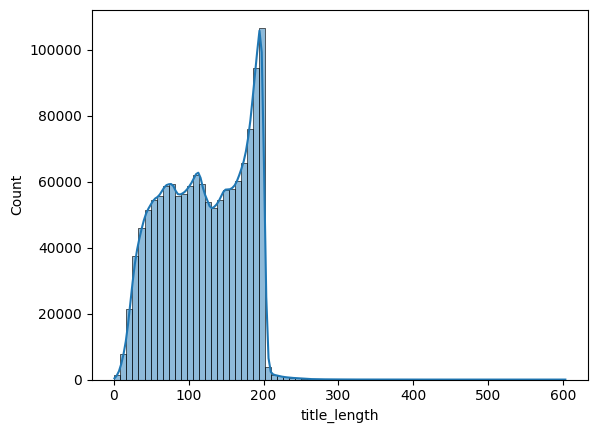

In [9]:
# create a histogram of title_length (df[['title_length']])

sns.histplot(df['title_length'], bins=75, kde=True)
plt.show()

In [31]:
# Define features and target

In [10]:
num_features = ['stars', 'reviews', 'price', 'listPrice','boughtInLastMonth', 'rating_weighted_reviews', 'percent_rank', 'price_log', 'title_length']
cat_features = ['has_listPrice', 'category_name', 'isPopular']
text_features = ['title']
target =['isBestSeller']

In [11]:
df.filter(num_features).corr()

,stars,reviews,price,listPrice,boughtInLastMonth,rating_weighted_reviews,percent_rank,price_log,title_length
stars,1.000000,0.026620,-0.028251,-0.013100,0.054848,0.029693,-0.018620,-0.037862,-0.046628
reviews,0.026620,1.000000,-0.009617,0.013005,0.148406,0.998888,0.224271,-0.015775,0.012843
price,-0.028251,-0.009617,1.000000,0.196255,-0.026223,-0.009612,-0.021813,0.567053,-0.036408
listPrice,-0.013100,0.013005,0.196255,1.000000,0.004348,0.012822,0.002559,0.338084,-0.050449
boughtInLastMonth,0.054848,0.148406,-0.026223,0.004348,1.000000,0.148523,0.001790,-0.060143,0.038441
rating_weighted_reviews,0.029693,0.998888,-0.009612,0.012822,0.148523,1.000000,0.223396,-0.015721,0.011860
percent_rank,-0.018620,0.224271,-0.021813,0.002559,0.001790,0.223396,1.000000,-0.024376,0.032168
price_log,-0.037862,-0.015775,0.567053,0.338084,-0.060143,-0.015721,-0.024376,1.000000,-0.106733
title_length,-0.046628,0.012843,-0.036408,-0.050449,0.038441,0.011860,0.032168,-0.106733,1.000000


In [12]:
X = df[num_features + cat_features + text_features]
y = df[target]

In [54]:
X

,stars,reviews,price,listPrice,boughtInLastMonth,rating_weighted_reviews,percent_rank,price_log,title_length,has_listPrice,category_name,isPopular,title
0,4.1,0,29.990000,0.000000,0,0.0,0.000000,3.433665,107,0,Girls' Shoes,0,"Toddler Sneakers, Kids Sneakers for Boys Girls..."
1,4.5,0,47.180000,65.949997,0,0.0,0.000000,3.874944,70,1,Girls' Shoes,0,"Kids Baby Classic Boot, Unicorn Awesome Print ..."
2,4.5,0,29.990000,37.990002,0,0.0,0.000000,3.433665,66,1,Girls' Shoes,0,Boys Dress Shoes Kids Casual Loafers Slip On U...
3,4.7,0,25.990000,0.000000,0,0.0,0.000000,3.295466,90,0,Girls' Shoes,0,Kid Ankle Boots Children Outdoor Shoes For Boy...
4,4.5,0,30.930000,0.000000,0,0.0,0.000000,3.463546,31,0,Girls' Shoes,0,Unisex-Child Outdoors Snow Boot
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1372582,4.5,281661,32.990002,39.990002,1000,1267474.5,0.999997,3.526066,198,1,Kids' Home Store,1,Queen Size Sheet Set - Breathable & Cooling Sh...
1372583,4.5,281661,32.990002,39.990002,2000,1267474.5,0.999997,3.526066,199,1,Kids' Home Store,1,Queen Size Sheet Set - Breathable & Cooling Sh...
1372584,4.5,281661,28.990000,38.990002,2000,1267474.5,0.999997,3.400864,200,1,Kids' Home Store,1,Full Size Sheet Set - Breathable & Cooling She...
1372585,4.0,292474,49.990002,0.000000,2000,1169896.0,0.999999,3.931630,145,0,Vacuum Cleaners & Floor Care,1,"ThisWorx Cordless Car Vacuum - Portable, Mini ..."


In [20]:
X = df[num_features + cat_features]
y = df[target]

# X_prior = preprocessor.fit_transform(X)
y_prior = y.values.ravel()


In [25]:
y_prior.shape

(1372587,)

In [21]:
y_prior2 = y.to_numpy().reshape(len(y), 1)

In [29]:
y_prior2.shape

(1372587, 1)

In [26]:
y_prior3 = np.array(y).reshape(-1, 1)
y_prior3.shape

(1372587, 1)

In [53]:
# Testing some code snippet


num_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="median")), ("scaler", StandardScaler())]
)

cat_transformer = Pipeline(
    steps=[
        ("imputer", SimpleImputer(strategy="constant", fill_value="missing")),
        ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False)),
    ]
)

preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, num_features),
        ("cat", cat_transformer, cat_features),
    ]
)

X = df[num_features + cat_features]
y = df[target]

# convert X to numpy array
X_prior = preprocessor.fit_transform(X)

In [35]:
y_prior = np.array(y).reshape(-1, 1)


In [50]:
X_prior.shape

(1372587, 261)

In [40]:
y_prior.shape

(1372587, 1)

In [54]:
print("X_prior shape:", X_prior.shape)
print("y_prior shape:", y_prior.shape)


X_prior shape: (1372587, 261)
y_prior shape: (1372587, 1)


In [52]:
X_prior = X_prior.to_numpy()

AttributeError: 'csr_matrix' object has no attribute 'to_numpy'

In [55]:
type(X_prior)

numpy.ndarray

In [56]:
combined = np.concatenate((X_prior, y_prior), axis=1)

In [57]:
combined.shape

(1372587, 262)

In [58]:
np.random.shuffle(combined) # Shuffle the data

In [63]:
train, validation, test = np.split(combined, [int(0.7 * len(X)), int(0.85 * len(X))])


In [65]:
# Print shatre of train, test and validation

print("Train shape:", train.shape)
print("Validation shape:", validation.shape)
print("Test shape:", test.shape)

Train shape: (960810, 262)
Validation shape: (205888, 262)
Test shape: (205889, 262)


In [68]:
205888/1372587

0.14999996357243658

In [17]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [18]:
y_train = y_train.values.ravel()  # Convert to numpy array and then flatten
y_test = y_test.values.ravel()    # Convert to numpy array and then flatten

In [19]:
y_train.size

1098069

In [15]:
print("Size of training set: ", X_train.shape)
print("Size of test set: ", X_test.shape)
print("Proportion of positive class in training set: ", y_train.mean())
print("Proportion of positive class in test set: ", y_test.mean())

Size of training set:  (54903, 13)
Size of test set:  (13726, 13)
Proportion of positive class in training set:  0.005500610167021839
Proportion of positive class in test set:  0.005464082762640245


In [17]:
# Preprocessing pipeline

numerical_preprocessor = Pipeline([
    ('scaler', StandardScaler())])
categorical_preprocessor = Pipeline([
    ('onehot', OneHotEncoder(handle_unknown='ignore'))])
# text_preprocessor = Pipeline([
#     ('bert', BertTextPreprocessr(tokenizer, model))])
text_preprocessor = Pipeline(steps=[
    ('tfidf', TfidfVectorizer(max_features=10000, stop_words='english'))
])

In [18]:
# pipeline = Pipeline([
#     ('preprocessor', preprocessor)
# ])

In [ ]:
X_train_transformed = pipeline.fit_transform(X_train)

## Debugging - without SMOTE

**Step 1: Numerical Preprocessing**

In [32]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num = scaler.transform(X_test[num_features])

# Debug: Check scaled values
print("Numerical Features (Train):", X_train_num.shape)


Numerical Features (Train): (54903, 9)


In [21]:
len(num_features)

9

In [22]:
X_test_num.shape

(13726, 9)

**Step 2: Categorical Preprocessing**

In [33]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_features])
X_test_cat = encoder.transform(X_test[cat_features])

# Debug: Check encoded values
print("Categorical Features (Train):", X_train_cat.shape)


Categorical Features (Train): (54903, 251)


In [24]:
X_train_cat.shape

(54903, 251)

**Step 3: Text Preprocessing**

In [25]:
text_features[0]

'title'

In [26]:
# Vectorize text features
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_text = tfidf.fit_transform(X_train[text_features[0]]).toarray()  # 'title' column
X_test_text = tfidf.transform(X_test[text_features[0]]).toarray()

# Debug: Check vectorized values
print("Text Features (Train):", X_train_text.shape)


Text Features (Train): (54903, 1000)


**Step 4: Combine Features**

In [27]:
print("X_train_num Type:", type(X_train_num), X_train_num.dtype)
print("X_train_cat Type:", type(X_train_cat), X_train_cat.dtype)
print("X_train_text Type:", type(X_train_text), X_train_text.dtype)


X_train_num Type: <class 'numpy.ndarray'> float64
X_train_cat Type: <class 'numpy.ndarray'> float64
X_train_text Type: <class 'numpy.ndarray'> float64


In [28]:
X_train_combined = np.hstack([X_train_num, X_train_cat, X_train_text])
X_test_combined = np.hstack([X_test_num, X_test_cat, X_test_text])

# Debug: Check final shape
print("Combined Features (Train):", X_train_combined.shape)
print("Combined Features (Test):", X_test_combined.shape)


Combined Features (Train): (54903, 1260)
Combined Features (Test): (13726, 1260)


**Step 5: Fit Model**

In [29]:
model = LogisticRegression(max_iter=200, random_state=42, penalty='l1',class_weight='balanced', solver='liblinear')
model.fit(X_train_combined, y_train)

# Evaluate the model
train_score = model.score(X_train_combined, y_train)
test_score = model.score(X_test_combined, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


Training Accuracy: 0.9594
Test Accuracy: 0.9509


In [ ]:
from sklearn.model_selection import cross_val_score
precision_scores = cross_val_score(model, X_train_combined, y_train, cv=5, scoring='precision')

print("Precision scores:", precision_scores)
print("Average Precision:", precision_scores.mean())


Precision scores: [0.03837953 0.03665988 0.04439252 0.04968944 0.04008439]
Average Precision: 0.0418411522522361


**NO text feature**

In [34]:
X_train_combined_notext = np.hstack([X_train_num, X_train_cat])
X_test_combined_notext = np.hstack([X_test_num, X_test_cat])

# Debug: Check final shape
print("Combined Features (Train):", X_train_combined_notext.shape)
print("Combined Features (Test):", X_test_combined_notext.shape)


Combined Features (Train): (54903, 260)
Combined Features (Test): (13726, 260)


In [35]:
model = LogisticRegression(max_iter=200, random_state=42, penalty='l1',class_weight='balanced', solver='liblinear')
model.fit(X_train_combined_notext, y_train)

precision_scores = cross_val_score(model, X_train_combined_notext, y_train, cv=5, scoring='precision')

print("Precision scores:", precision_scores)
print("Average Precision:", precision_scores.mean())


Precision scores: [0.02400835 0.02166847 0.02572899 0.02256034 0.02176279]
Average Precision: 0.02314578650296579


## Debugging - with SMOTE

In [55]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Step 1: Numerical Preprocessing**

In [56]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num = scaler.transform(X_test[num_features])

# Debug: Check scaled values
print("Numerical Features (Train):", X_train_num.shape)


Numerical Features (Train): (1098069, 9)


In [57]:
len(num_features)

9

In [58]:
X_test_num.shape

(274518, 9)

**Step 2: Categorical Preprocessing**

In [59]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_features])
X_test_cat = encoder.transform(X_test[cat_features])

# Debug: Check encoded values
print("Categorical Features (Train):", X_train_cat.shape)


Categorical Features (Train): (1098069, 252)


In [60]:
X_train_cat.shape

(1098069, 252)

**Step 3: Text Preprocessing**

In [61]:
text_features[0]

'title'

In [62]:
# Vectorize text features
tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
X_train_text = tfidf.fit_transform(X_train[text_features[0]]).toarray()  # 'title' column
X_test_text = tfidf.transform(X_test[text_features[0]]).toarray()

# Debug: Check vectorized values
print("Text Features (Train):", X_train_text.shape)


Text Features (Train): (1098069, 1000)


**Step 4: Combine Features**

In [63]:
print("X_train_num Type:", type(X_train_num), X_train_num.dtype)
print("X_train_cat Type:", type(X_train_cat), X_train_cat.dtype)
print("X_train_text Type:", type(X_train_text), X_train_text.dtype)


X_train_num Type: <class 'numpy.ndarray'> float64
X_train_cat Type: <class 'numpy.ndarray'> float64
X_train_text Type: <class 'numpy.ndarray'> float64


In [64]:
X_train_combined = np.hstack([X_train_num, X_train_cat, X_train_text])
X_test_combined = np.hstack([X_test_num, X_test_cat, X_test_text])

# Debug: Check final shape
print("Combined Features (Train):", X_train_combined.shape)
print("Combined Features (Test):", X_test_combined.shape)


MemoryError: Unable to allocate 10.3 GiB for an array with shape (1098069, 1261) and data type float64

**Step 5: SMOTE**

In [21]:
# Shape of training and test sets
print("Size of combined, proprocessed training set: ", X_train_combined.shape)
print("Size of combined, proprocessed test set: ", X_test_combined.shape)
print("Proportion of positive class in training set: ", y_train.mean())
print("Proportion of positive class in test set: ", y_test.mean())
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Size of combined, proprocessed training set:  (54903, 1260)
Size of combined, proprocessed test set:  (13726, 1260)
Proportion of positive class in training set:  isBestSeller    0.005501
dtype: float64
Proportion of positive class in test set:  isBestSeller    0.005464
dtype: float64
Shape of y_train:  (54903, 1)
Shape of y_test:  (13726, 1)


In [22]:
# SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

In [23]:
# Shapre after SMOTE
print("Size of resampled training set: ", X_train_resampled.shape)
print("Proportion of positive class in resampled training set: ", y_train_resampled.mean())
print("Shape of y_train_resampled: ", y_train_resampled.shape)

Size of resampled training set:  (109202, 1260)
Proportion of positive class in resampled training set:  isBestSeller    0.5
dtype: float64
Shape of y_train_resampled:  (109202, 1)


**Step 6: Fit Model**

In [24]:
model = LogisticRegression(max_iter=200, random_state=42, penalty='l1',class_weight='balanced', solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_score = model.score(X_train_resampled, y_train_resampled)
test_score = model.score(X_test_combined, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.9843
Test Accuracy: 0.9598


In [25]:
from sklearn.model_selection import cross_val_score
precision_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='precision')

print("Precision scores:", precision_scores)
print("Average Precision:", precision_scores.mean())


c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documen

Precision scores: [0.96126761 0.95840281 0.96304789 0.96245373 0.96101382]
Average Precision: 0.9612371693327431


In [27]:
# Precision on test set
from sklearn.metrics import precision_score
y_pred = model.predict(X_test_combined)
precision = precision_score(y_test, y_pred)
print("Precision on test set:", precision)

Precision on test set: 0.03868471953578337


In [ ]:
# Why is precision on cross-validation 0.98 and on test set 0.03:
# 1. The model is overfitting on the training set and not generalizing well to the test set, despite over-sampling
# 2. The model is not learning the patterns in the data well, and is making predictions that are not accurate
# 3. We did SMOTE on train set and not on test set, so the model is not learning the patterns in the test set. But we're not supposed to do SMOTE on test set because it's cheating and we're not supposed to touch the test set at all. So, we need to figure out how to make the model learn the patterns in the training set better, so that it can generalize well to the test set.
# One of the ways to do this is to use cross-validation to evaluate the model on the training set, and then use the best model to make predictions on the test set. This way, we can ensure that the model is learning the patterns in the training set well, and is generalizing well to the test set.


## Debugging - remove text? Focus on numerical + categorical

In [34]:
# Train test split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

**Step 1: Numerical Preprocessing**

In [35]:
scaler = StandardScaler()
X_train_num = scaler.fit_transform(X_train[num_features])
X_test_num = scaler.transform(X_test[num_features])

# Debug: Check scaled values
print("Numerical Features (Train):", X_train_num.shape)


Numerical Features (Train): (54903, 9)


In [36]:
len(num_features)

9

In [37]:
X_test_num.shape

(13726, 9)

**Step 2: Categorical Preprocessing**

In [38]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = encoder.fit_transform(X_train[cat_features])
X_test_cat = encoder.transform(X_test[cat_features])

# Debug: Check encoded values
print("Categorical Features (Train):", X_train_cat.shape)


Categorical Features (Train): (54903, 251)


In [39]:
X_train_cat.shape

(54903, 251)

**Step 3: Text Preprocessing**

In [ ]:
# text_features[0]

'title'

In [ ]:
# # Vectorize text features
# tfidf = TfidfVectorizer(stop_words='english', max_features=1000)
# X_train_text = tfidf.fit_transform(X_train[text_features[0]]).toarray()  # 'title' column
# X_test_text = tfidf.transform(X_test[text_features[0]]).toarray()

# # Debug: Check vectorized values
# print("Text Features (Train):", X_train_text.shape)


Text Features (Train): (54903, 1000)


**Step 4: Combine Features**

In [41]:
print("X_train_num Type:", type(X_train_num), X_train_num.dtype)
print("X_train_cat Type:", type(X_train_cat), X_train_cat.dtype)
# print("X_train_text Type:", type(X_train_text), X_train_text.dtype)


X_train_num Type: <class 'numpy.ndarray'> float64
X_train_cat Type: <class 'numpy.ndarray'> float64


In [42]:
X_train_combined = np.hstack([X_train_num, X_train_cat])
X_test_combined = np.hstack([X_test_num, X_test_cat])

# Debug: Check final shape
print("Combined Features (Train):", X_train_combined.shape)
print("Combined Features (Test):", X_test_combined.shape)


Combined Features (Train): (54903, 260)
Combined Features (Test): (13726, 260)


**Step 5: SMOTE**

In [43]:
# Shape of training and test sets
print("Size of combined, proprocessed training set: ", X_train_combined.shape)
print("Size of combined, proprocessed test set: ", X_test_combined.shape)
print("Proportion of positive class in training set: ", y_train.mean())
print("Proportion of positive class in test set: ", y_test.mean())
print("Shape of y_train: ", y_train.shape)
print("Shape of y_test: ", y_test.shape)

Size of combined, proprocessed training set:  (54903, 260)
Size of combined, proprocessed test set:  (13726, 260)
Proportion of positive class in training set:  isBestSeller    0.005501
dtype: float64
Proportion of positive class in test set:  isBestSeller    0.005464
dtype: float64
Shape of y_train:  (54903, 1)
Shape of y_test:  (13726, 1)


In [44]:
# SMOTE
smote = SMOTE(random_state=42, sampling_strategy='minority')
X_train_resampled, y_train_resampled = smote.fit_resample(X_train_combined, y_train)

In [45]:
# Shapre after SMOTE
print("Size of resampled training set: ", X_train_resampled.shape)
print("Proportion of positive class in resampled training set: ", y_train_resampled.mean())
print("Shape of y_train_resampled: ", y_train_resampled.shape)

Size of resampled training set:  (109202, 260)
Proportion of positive class in resampled training set:  isBestSeller    0.5
dtype: float64
Shape of y_train_resampled:  (109202, 1)


**Step 6: Fit Model**

In [46]:
model = LogisticRegression(max_iter=200, random_state=42, penalty='l1',class_weight='balanced', solver='liblinear')
model.fit(X_train_resampled, y_train_resampled)

# Evaluate the model
train_score = model.score(X_train_resampled, y_train_resampled)
test_score = model.score(X_test_combined, y_test)

print(f"Training Accuracy: {train_score:.4f}")
print(f"Test Accuracy: {test_score:.4f}")


c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Training Accuracy: 0.8878
Test Accuracy: 0.8504


In [47]:
from sklearn.model_selection import cross_val_score
precision_scores = cross_val_score(model, X_train_resampled, y_train_resampled, cv=5, scoring='precision')

print("Precision scores:", precision_scores)
print("Average Precision:", precision_scores.mean())


c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documents\GitHub\Advanced-Classification-for-Imbalanced-Data\venv_aws\Lib\site-packages\sklearn\utils\validation.py:1339: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\shefa\Documen

Precision scores: [0.86311461 0.85911389 0.86121057 0.86491348 0.85975139]
Average Precision: 0.8616207904747075


In [48]:
# Precision on test set
from sklearn.metrics import precision_score
y_pred = model.predict(X_test_combined)
precision = precision_score(y_test, y_pred)
print("Precision on test set:", precision)

Precision on test set: 0.02588686481303931


In [65]:
# Check feature importance

from sklearn.inspection import permutation_importance

result = permutation_importance(model, X_train_resampled, y_train_resampled, n_repeats=10, random_state=42, n_jobs=2)

In [67]:
sorted_idx = result.importances_mean.argsort()

In [72]:
categorical_feature_names = encoder.get_feature_names_out(cat_features)

# Combine numerical and categorical feature names
feature_names = num_features + list(categorical_feature_names)


In [74]:
sorted_feature_names = [feature_names[i] for i in sorted_idx if i < len(feature_names)]
sorted_importances = result.importances_mean[sorted_idx]


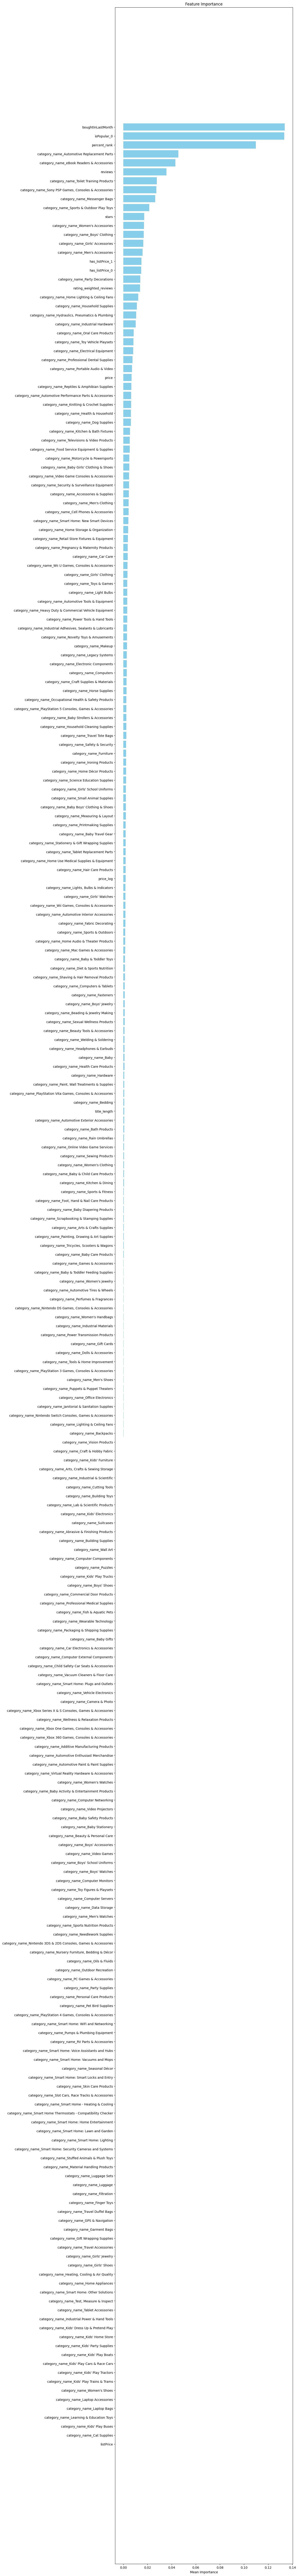

In [76]:

plt.figure(figsize=(10, 145))
plt.barh(sorted_feature_names, sorted_importances, color='skyblue')
plt.xlabel("Mean Importance")
plt.title("Feature Importance")
plt.show()